In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import igraph as ig
import itertools as it
import random
from scipy.special import loggamma
from pyitlib import discrete_random_variable as drv
import matplotlib.pyplot as plt
from joblib import Parallel,delayed
import pickle
import time

def generate_synthetic(S,N,modes,alphas,betas,pis):
    
    def ind2ij(ind,N):
        i = N - 2 - np.floor(np.sqrt(-8*ind + 4*N*(N-1)-7)/2.0 - 0.5)
        j = ind + i + 1 - N*(N-1)/2 + (N-i)*((N-i)-1)/2
        return int(i),int(j)
    
    K = len(modes)
    NC2 = int(N*(N-1)/2)
    nets,cluster_labels = [],[]
    for t in range(S):
        k = np.random.choice(range(K),p=pis)
        Mk = len(modes[k])
        net = set()
        for e in modes[k]:
            if np.random.rand() < alphas[k]: net.add(e)
        num_fps = np.random.binomial(NC2-Mk,betas[k])
        while num_fps > 0:
            ind = np.random.randint(NC2-1)
            i,j = ind2ij(ind,N)
            if not((i,j) in modes[k]):
                net.add((i,j))
                num_fps -= 1
        nets.append(net)
        cluster_labels.append(k)
         
    return nets,cluster_labels 

def remap_keys(Dict):
    sorted_keys = sorted(list(Dict.keys()))
    for i,u in enumerate(sorted_keys):
        Dict[i] = Dict.pop(u)
    return Dict

# clustering class and reconstruction code

In [2]:
class MDL_populations():
    
    def __init__(self, edgesets, N, K0 = 1, n_fails = 100, bipartite = None):
        self.edgesets = edgesets
        self.K0 = K0
        self.n_fails = n_fails
        self.S = len(self.edgesets)
        if bipartite is None:
            self.N = N
            self.NC2 = self.N*(self.N-1)/2
        else:
            self.NC2 = bipartite[0]*bipartite[1]
        self.C,self.E,self.A = {},{},{}
        self.attmerges,self.attsplits,self.attmergesplits = set(),set(),set()
    
    def initialize_clusters(self):
        for i,s in enumerate(np.random.permutation(range(self.S))):
            k = str(i % self.K0)
            if k in self.C: 
                self.C[k].add(s)
            else: 
                self.C[k] = set()
                self.C[k].add(s)
        for k in range(self.K0):
            k = str(k)
            self.E[k] = self.generate_Ek(self.C[k])
            self.A[k] = self.update_mode(self.E[k],len(self.C[k]))
        self.L = sum([self.Lk(self.A[k],self.E[k],len(self.C[k])) for k in self.C])
            
    def random_key(self): return str(np.random.randint(1000000000000))
    
    def logchoose(self,N,K): return loggamma(N+1) - loggamma(N-K+1) - loggamma(K+1)
    
    def logmult(self,Ns): return loggamma(sum(Ns)+1) - sum(loggamma(i+1) for i in Ns)
    
    def generate_Ek(self,cluster): 
        Ek = {}
        for s in cluster:
            for e in self.edgesets[s]:
                if e in Ek:
                    Ek[e] += 1
                else:
                    Ek[e] = 1             
        return Ek
    
#     def update_mode(self,Ek,Sk):
#         Etil = sorted(Ek.items(),key=lambda x:x[1],reverse=True)
#         r,tk,fk,Mk,Ak = 0,0,sum(Ek.values()),0,set()
#         Mmax = len(Ek)
#         while (r < Mmax): #and (tk >= Mk*Sk/2):
#             e,Xij = Etil[r]
#             Lafter = self.logchoose(self.NC2,Mk+1) + Sk*np.log(self.S/Sk) + self.logchoose(Sk*(Mk+1),tk+Xij) + self.logchoose(Sk*(self.NC2-(Mk+1)),fk-Xij)
#             Lbefore = self.logchoose(self.NC2,Mk) + Sk*np.log(self.S/Sk) + self.logchoose(Sk*Mk,tk) + self.logchoose(Sk*(self.NC2-Mk),fk)
#             print('Sk:',Sk,'Mk:',Mk,'tk:',tk,'fk:',fk,'NC2:',self.NC2,'Xij:',Xij)
#             deltaLadd = Lafter - Lbefore
#             if (deltaLadd <= 0):
#                 Ak.add(e)
#                 r += 1
#                 tk += Xij
#                 fk -= Xij
#                 Mk += 1
#             else:
#                 return Ak
#         return Ak
    
    def update_mode(self,Ek,Sk):
        Etil = sorted(Ek.items(),key=lambda x:x[1])
        r,tk,fk,Mk,Ak = 0,sum(Ek.values()),0,len(Ek),set(Ek.keys())
        Mmax = len(Ek)
        while (r < Mmax): #and (tk >= Mk*Sk/2):
            e,Xij = Etil[r]
            Lafter = self.logchoose(self.NC2,Mk-1) + Sk*np.log(self.S/Sk) + self.logchoose(Sk*(Mk-1),tk-Xij) + self.logchoose(Sk*(self.NC2-(Mk-1)),fk+Xij)
            Lbefore = self.logchoose(self.NC2,Mk) + Sk*np.log(self.S/Sk) + self.logchoose(Sk*Mk,tk) + self.logchoose(Sk*(self.NC2-Mk),fk)
            deltaLadd = Lafter - Lbefore
            if (deltaLadd <= 0):
                Ak.discard(e)
                r += 1
                tk -= Xij
                fk += Xij
                Mk -= 1
            else:
                return Ak
        return Ak
            
    def Lk(self,Ak,Ek,Sk):
        if Sk == 0: return 0.
        Mk = len(Ak)
        tk,fk = 0,sum(Ek.values()) 
        for e in Ak:
            if e in Ek:
                tk += Ek[e]
                fk -= Ek[e]
        return self.logchoose(self.NC2,Mk) + Sk*np.log(self.S/Sk) + self.logchoose(Sk*Mk,tk) + self.logchoose(Sk*(self.NC2-Mk),fk)
            
    def move1(self):
        ks = list(self.C.keys())
        k = random.choice(ks)
        if len(self.C[k]) == 1: return self.move2()
        if len(self.C) == 1: return self.move3()
        else:
            s = np.random.choice(list(self.C[k]))
            Ek_after = self.E[k].copy()
            for e in self.edgesets[s]: 
                Ek_after[e] -= 1
                if Ek_after[e] == 0: del Ek_after[e]
            deltaL1s = {}
            L_kbefore = self.Lk(self.A[k],self.E[k],len(self.C[k]))
            ks = list(self.C.keys())
            for kp in set(ks) - set({k}):
                L_kpbefore = self.Lk(self.A[kp],self.E[kp],len(self.C[kp]))
                Ekp_after = self.E[kp].copy()
                for e in self.edgesets[s]: 
                    if e in Ekp_after: Ekp_after[e] += 1
                    else: Ekp_after[e] = 1
                deltaL1s[kp] = self.Lk(self.A[kp],Ekp_after,len(self.C[kp])+1) + self.Lk(self.A[k],Ek_after,len(self.C[k])-1) - L_kbefore - L_kpbefore
            if min(deltaL1s.values()) < 0:
                min_kp = min(deltaL1s, key=deltaL1s.get)
                self.C[k].discard(s)
                self.C[kp].add(s)
                for e in self.edgesets[s]:
                    self.E[k][e] -= 1
                    if self.E[k][e] == 0: self.E[k].pop(e, None)
                    if e in self.E[kp]: self.E[kp][e] += 1
                    else: self.E[kp][e] = 1
                knew,kpnew = self.random_key(),self.random_key()        
                self.C[knew] = self.C.pop(k)
                self.C[kpnew] = self.C.pop(kp)
                self.E[knew] = self.E.pop(k)
                self.E[kpnew] = self.E.pop(kp)
                self.A[knew] = self.A.pop(k)
                self.A[kpnew] = self.A.pop(kp)
                self.attmerges,self.attsplits,self.attmergesplits = set(),set(),set()
                return True, deltaL1s[min_kp]
            else:
                return False, 0
                   
    def move2(self):
        if len(self.C) == 1: return self.move3()
        ks = list(self.C.keys())
        kp,kpp = np.random.choice(ks,size=2,replace=False)
        if ((kp,kpp) in self.attmerges) or ((kpp,kp) in self.attmerges): return False,0
        Ek = self.E[kp].copy()
        for e in self.E[kpp]:
            if e in Ek: Ek[e] += self.E[kpp][e]
            else: Ek[e] = self.E[kpp][e]
        Skp,Skpp = len(self.C[kp]),len(self.C[kpp])
        Sk = Skp + Skpp
        Ak = self.update_mode(Ek,Sk)
        deltaL2 = self.Lk(Ak,Ek,Sk) - self.Lk(self.A[kp],self.E[kp],Skp) - self.Lk(self.A[kpp],self.E[kpp],Skpp)
        if deltaL2 < 0:
            k = self.random_key()
            self.C[k] = self.C[kp].union(self.C[kpp])
            del self.C[kp]
            del self.C[kpp]
            self.E[k] = Ek.copy()
            del self.E[kp]
            del self.E[kpp]
            self.A[k] = Ak.copy()
            del self.A[kp]
            del self.A[kpp]
            self.attmerges,self.attsplits,self.attmergesplits = set(),set(),set()
            return True, deltaL2   
        else:
            self.attmerges.add((kp,kpp))
            return False, 0
        
    def move3(self):
        ks = list(self.C.keys())
        k = random.choice(ks)
        if len(self.C[k]) == 1: return self.move2()
        if k in self.attsplits: return False,0
        Sk = len(self.C[k])
        localC = {0:set(),1:set()}
        for i,s in enumerate(np.random.permutation(list(self.C[k]))): localC[i % 2].add(s)
        localS,localE,localA,localL = {0:None,1:None},{0:None,1:None},{0:None,1:None},{0:None,1:None}
        for kl in [0,1]:
            localS[kl] = len(localC[kl])
            localE[kl] = self.generate_Ek(localC[kl])
            localA[kl] = self.update_mode(localE[kl],localS[kl])
            localL[kl] = self.Lk(localA[kl],localE[kl],localS[kl])
        movement = True
        num_iters,max_2means = 0,10
        while (movement == True) and (num_iters < max_2means):
            movement = False
            to_move = []
            localEafter = {}
            for s in self.C[k]:
                for kl in [0,1]: localEafter[kl] = localE[kl].copy()
                if s in localC[0]: old,new = 0,1
                else: old,new = 1,0
                for e in self.edgesets[s]:
                    if e in localEafter[new]: localEafter[new][e] += 1
                    else: localEafter[new][e] = 1
                    localEafter[old][e] -= 1
                    if localEafter[old][e] == 0: del localEafter[old][e]
                deltaLmove = self.Lk(localA[new],localEafter[new],len(localC[new])+1) \
                                + self.Lk(localA[old],localEafter[old],len(localC[old])-1) \
                                    - localL[0] - localL[1]
                if deltaLmove < 0:
                    to_move.append((s,old,new))
                    movement = True
            for tup in to_move:
                s,old,new = tup
                localC[new].add(s)
                localC[old].discard(s)
                localS[new] += 1
                localS[old] -= 1
                if localS[old] == 0:
                    return self.move2()
                for e in self.edgesets[s]:
                    if e in localE[new]: localE[new][e] += 1
                    else: localE[new][e] = 1
                    localE[old][e] -= 1
                    if localE[old][e] == 0: del localE[old][e]
            for kl in [0,1]:
                localA[kl] = self.update_mode(localE[kl],localS[kl])
                localL[kl] = self.Lk(localA[kl],localE[kl],localS[kl])
            num_iters += 1

        deltaL3 = self.Lk(localA[0],localE[0],localS[0]) + self.Lk(localA[1],localE[1],localS[1]) - self.Lk(self.A[k],self.E[k],Sk)   
        if deltaL3 < 0:
            kp,kpp = self.random_key(),self.random_key()
            self.C[kp] = localC[0].copy()
            self.C[kpp] = localC[1].copy()
            del self.C[k]
            self.E[kp] = localE[0].copy()
            self.E[kpp] = localE[1].copy()
            del self.E[k]
            self.A[kp] = localA[0].copy()
            self.A[kpp] = localA[1].copy()
            del self.A[k]
            self.attmerges,self.attsplits,self.attmergesplits = set(),set(),set()
            return True,deltaL3 
        else:
            self.attmerges.add(k)
            return False, 0
        
    def move4(self):
        if len(self.C) == 1: return self.move3()
        ks = list(self.C.keys())
        k1,k2 = np.random.choice(ks,size=2,replace=False)
        if ((k1,k2) in self.attmergesplits) or ((k2,k1) in self.attmergesplits): return False,0 
        Ck = self.C[k1].union(self.C[k2])
        Sk = len(Ck)
        localC = {0:set(),1:set()}
        for i,s in enumerate(np.random.permutation(list(Ck))): localC[i % 2].add(s)
        localS,localE,localA,localL = {0:None,1:None},{0:None,1:None},{0:None,1:None},{0:None,1:None}
        for kl in [0,1]:
            localS[kl] = len(localC[kl])
            localE[kl] = self.generate_Ek(localC[kl])
            localA[kl] = self.update_mode(localE[kl],localS[kl])
            localL[kl] = self.Lk(localA[kl],localE[kl],localS[kl])
        movement = True
        num_iters,max_2means = 0,10
        while (movement == True) and (num_iters < max_2means):
            movement = False
            to_move = []
            localEafter = {}
            for s in Ck:
                for kl in [0,1]: localEafter[kl] = localE[kl].copy()
                if s in localC[0]: old,new = 0,1
                else: old,new = 1,0
                for e in self.edgesets[s]:
                    if e in localEafter[new]: localEafter[new][e] += 1
                    else: localEafter[new][e] = 1
                    localEafter[old][e] -= 1
                    if localEafter[old][e] == 0: del localEafter[old][e]
                deltaLmove = self.Lk(localA[new],localEafter[new],len(localC[new])+1) \
                                + self.Lk(localA[old],localEafter[old],len(localC[old])-1) \
                                    - localL[0] - localL[1]
                if deltaLmove < 0:
                    to_move.append((s,old,new))
                    movement = True
            for tup in to_move:
                s,old,new = tup
                localC[new].add(s)
                localC[old].discard(s)
                localS[new] += 1
                localS[old] -= 1
                if localS[old] == 0:
                    return self.move2()
                for e in self.edgesets[s]:
                    if e in localE[new]: localE[new][e] += 1
                    else: localE[new][e] = 1
                    localE[old][e] -= 1
                    if localE[old][e] == 0: del localE[old][e]
            for kl in [0,1]:
                localA[kl] = self.update_mode(localE[kl],localS[kl])
                localL[kl] = self.Lk(localA[kl],localE[kl],localS[kl])
            num_iters += 1

        deltaL4 = self.Lk(localA[0],localE[0],localS[0]) + self.Lk(localA[1],localE[1],localS[1]) \
                                        - self.Lk(self.A[k1],self.E[k1],len(self.C[k1])) - self.Lk(self.A[k2],self.E[k2],len(self.C[k2]))  
        if deltaL4 < 0:
            kp,kpp = self.random_key(),self.random_key()
            self.C[kp] = localC[0].copy()
            self.C[kpp] = localC[1].copy()
            del self.C[k1]
            del self.C[k2]
            self.E[kp] = localE[0].copy()
            self.E[kpp] = localE[1].copy()
            del self.E[k1]
            del self.E[k2]
            self.A[kp] = localA[0].copy()
            self.A[kpp] = localA[1].copy()
            del self.A[k1]
            del self.A[k2]
            self.attmerges,self.attsplits,self.attmergesplits = set(),set(),set()
            return True,deltaL4 
        else:
            self.attmergesplits.add((k1,k2))
            return False, 0

    def run_sims(self):
        nf,max_runs,runs = 0,10000,0
        while (nf < self.n_fails) and (runs < max_runs):
            move = np.random.choice([1,2,3,4])
            accepted,deltaL = eval('self.move'+str(move)+'()')
            if accepted: nf = 0
            else: nf += 1
            self.L += deltaL
            runs += 1

        M = sum([len(D) for D in self.edgesets])
        self.L /= self.logchoose(self.S*self.NC2,M)
    
        return remap_keys(self.C),remap_keys(self.E),remap_keys(self.A),self.L
    
    def initialize_contiguous(self):
        self.Cadj = {}
        for k in range(self.S):
            self.Cadj[str(k)] = set()
            if k != 0: 
                self.Cadj[str(k)].add(str(k-1))
            if k != (self.S-1): 
                self.Cadj[str(k)].add(str(k+1))
            self.C[str(k)] = set()
            self.C[str(k)].add(k)
            self.A[str(k)] = self.edgesets[k].copy()
            self.E[str(k)] = dict(zip(self.edgesets[k],np.ones(len(self.edgesets[k]))))
        self.L = sum([self.Lk(self.A[k],self.E[k],len(self.C[k])) for k in self.C])
        self.attmerges = {}
    
    def cont_merge(self,kp,kpp,update):

        merged = self.C[kp].union(self.C[kpp])
        if not(tuple(sorted((kp,kpp))) in self.attmerges):
            Ek = self.E[kp].copy()
            for e in self.E[kpp]:
                if e in Ek: Ek[e] += self.E[kpp][e]
                else: Ek[e] = self.E[kpp][e]
            Skp,Skpp = len(self.C[kp]),len(self.C[kpp])
            Sk = Skp + Skpp
            Ak = self.update_mode(Ek,Sk)
            delta_L = self.Lk(Ak,Ek,Sk) - self.Lk(self.A[kp],self.E[kp],Skp) - self.Lk(self.A[kpp],self.E[kpp],Skpp)
            self.attmerges[tuple(sorted((kp,kpp)))] =  (Ek,Ak,delta_L)
        Ek,Ak,delta_L = self.attmerges[tuple(sorted((kp,kpp)))]
        
        if (delta_L < 0) and (update == True):
            del self.C[kp]
            del self.C[kpp]
            past_neigs = self.Cadj[kp].union(self.Cadj[kpp])
            past_neigs.discard(kp)
            past_neigs.discard(kpp)
            del self.attmerges[tuple(sorted((kp,kpp)))]
            del self.Cadj[kp]
            del self.Cadj[kpp]
            k = self.random_key()
            self.C[k] = merged.copy()
            self.Cadj[k] = past_neigs
            for neig in past_neigs:
                self.Cadj[neig].add(k)
                self.Cadj[neig].discard(kp)
                self.Cadj[neig].discard(kpp)
            del self.A[kp]
            del self.A[kpp]
            self.A[k] = Ak
            del self.E[kp]
            del self.E[kpp]
            self.E[k] = Ek
            
        return min([delta_L,0])
    
    def run_sims_contiguous(self):
        
        while len(self.C) > 1:
            all_pairs = [(key1,key2) for key1 in self.Cadj for key2 in self.Cadj[key1] if (key2 > key1)]
            neg_pairs,neg_deltas = [],[]
            for pair in all_pairs:
                kp,kpp = pair
                delta = self.cont_merge(kp,kpp,update=False)
                if delta < 0:
                    neg_pairs.append(pair)
                    neg_deltas.append(delta)
           
            if len(neg_deltas) == 0:
                M = sum([len(D) for D in self.edgesets])
                self.L /= self.logchoose(self.S*self.NC2,M)
                return remap_keys(self.C),remap_keys(self.E),remap_keys(self.A),self.L  
            else:
                best_ind = np.argmin(neg_deltas)
                kp,kpp = neg_pairs[best_ind]
                delta_L = self.cont_merge(kp,kpp,update=True)
                self.L += delta_L
                
        M = sum([len(D) for D in self.edgesets])
        self.L /= self.logchoose(self.S*self.NC2,M)
                
        return remap_keys(self.C),remap_keys(self.E),remap_keys(self.A),self.L 
    
def synthetic_reconstruction(S,N,modes,alphas,betas,pis,K0,n_fails,n_reruns):
    
    Ktrue = len(modes)
    all_mode_dists,all_label_dists,all_Ls,all_modes = [],[],[],[]
    for _ in range(n_reruns):
        D,true_labels = generate_synthetic(S,N,modes,alphas,betas,pis)
        MDLobj = MDL_populations(D,N,K0,n_fails)
        MDLobj.initialize_clusters()
        C,E,A,L = MDLobj.run_sims()
        inferred_labels = [p[1] for p in sorted({node:c for c in C for node in C[c] }.items(),key=lambda x: x[0])]
        label_dist = drv.information_variation(true_labels,inferred_labels)
        mode_dists = []
        for ki in A:
            mode_dists_ki = []
            for kt in range(Ktrue):
                hamming = 2*(len(modes[kt] - A[ki]) + len(A[ki] - modes[kt]))
                mode_dists_ki.append(hamming)
            mode_dists.append(min(mode_dists_ki))
        mode_dist = sum(sorted(mode_dists)[:2])  
        all_mode_dists.append(mode_dist)
        all_label_dists.append(label_dist)
        all_Ls.append(L)
        all_modes.append(A)
       
    return [np.mean(all_mode_dists),np.mean(all_label_dists),np.mean(all_Ls)]

def synthetic_reconstruction_contiguous(true_labels,N,modes,alphas,betas,n_reruns):
    
    Ktrue = len(modes)
    S = len(true_labels)
    all_mode_dists,all_label_dists,all_Ls,all_modes = [],[],[],[]
    for _ in range(n_reruns):
        D = [generate_synthetic(1,N,[modes[l%Ktrue]],[alphas[l%Ktrue]],[betas[l%Ktrue]],[1.])[0][0] for l in true_labels]
        MDLobj = MDL_populations(D,N,K0=np.inf,n_fails=np.inf)
        MDLobj.initialize_contiguous()
        C,E,A,L = MDLobj.run_sims_contiguous()
        inferred_labels = [p[1] for p in sorted({node:c for c in C for node in C[c] }.items(),key=lambda x: x[0])]
        label_dist = drv.information_variation(true_labels,inferred_labels)

        mode_dists = []
        for ki in A:
            mode_dists_ki = []
            for kt in range(Ktrue):
                hamming = 2*(len(modes[kt] - A[ki]) + len(A[ki] - modes[kt]))
                mode_dists_ki.append(hamming)
            mode_dists.append(min(mode_dists_ki))
        mode_dist = sum(sorted(mode_dists)[:2])   
        all_mode_dists.append(mode_dist)
        all_label_dists.append(label_dist)
        all_Ls.append(L)
        all_modes.append(A)
   
    return [np.mean(all_mode_dists),np.mean(all_label_dists),np.mean(all_Ls)]

# reconstructions

In [3]:
# flip_ps = np.linspace(0.01,0.5,20)
# modes = [{(0,1),(1,5),(4,5),(0,4),(0,5),(1,4),(1,2),(3,7),(6,7)},\
#              {(1,2),(2,6),(5,6),(1,5),(1,6),(2,5),(0,1),(0.4),(2,3)},\
#              {(2,3),(3,7),(6,7),(2,6),(2,7),(3,6),(4,5),(1,5),(5,6)}]
# N = 8
# modes = [modes[0],modes[2]]
# all_recovery_results = {}
# param_combos = [(100,'non'),(100,'cont2'),(100,'cont4')]
# for combo in param_combos:
    
    
#     S = combo[0]
#     if combo[1] == 'non':
#         start = time.time()
#         all_recovery_results[combo] = Parallel(n_jobs=10)(delayed(synthetic_reconstruction)(S=S,N=N,modes=modes,alphas=(1-p)*np.ones(2),\
#                                                                              betas=p*np.ones(2),pis=[0.5,0.5],\
#                                                                                K0=1,n_fails=500,n_reruns=200)\
#                                                                                for p in flip_ps)
#         duration = time.time() - start
    
#     elif combo[1] == 'cont2':
#         true_labels = [0]*int(S/2) + [1]*int(S/2)
#         all_recovery_results[combo] = Parallel(n_jobs=10)(delayed(synthetic_reconstruction_contiguous)(true_labels=true_labels,N=N,modes=modes,\
#                                                                                 alphas=(1-p)*np.ones(2),\
#                                                                              betas=p*np.ones(2),n_reruns=200)\
#                                                                                for p in flip_ps)
    
#     elif combo[1] == 'cont4':
#         true_labels = [0]*int(S/4) + [1]*int(S/4) + [2]*int(S/4) + [3]*int(S/4)
#         all_recovery_results[combo] = Parallel(n_jobs=10)(delayed(synthetic_reconstruction_contiguous)(true_labels=true_labels,N=N,modes=modes,\
#                                                                                 alphas=(1-p)*np.ones(2),\
#                                                                              betas=p*np.ones(2),n_reruns=200)\
#                                                                                for p in flip_ps)
    
# with open('results/reconstructions.pkl','wb') as f:
#     pickle.dump(all_recovery_results,f)
    
with open('results/reconstructions.pkl','rb') as f:
    all_recovery_results = pickle.load(f)
    
with open('results/recovery_new_modes_equal_density.pkl','rb') as f:
    gibbs_results = pickle.load(f)

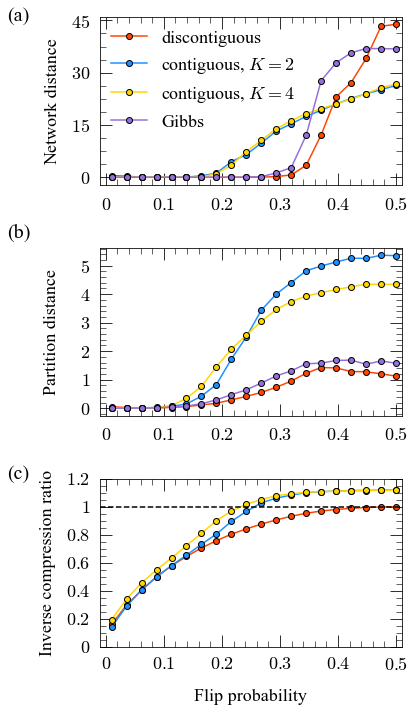

In [6]:
#colors = ['orangered','dodgerblue','gold','mediumpurple','limegreen','lightpink']
#colors = ['lightcoral','deepskyblue','limegreen']
colors = ['orangered','dodgerblue','gold'] + ['orangered','dodgerblue','gold']
markers = ['o','^','s']
curve_labels = [r'discontiguous',r'contiguous, $K=2$',r'contiguous, $K=4$']
yaxislabels = ['Network distance','Partition distance','Inverse compression ratio']
yticks_arr = [[0,15,30,45],[0,1,2,3,4,5,6],[0,0.2,0.4,0.6,0.8,1,1.2]]
flip_ps = np.linspace(0.01,0.5,20)
param_combos = [(100,'non'),(100,'cont2'),(100,'cont4')]

fontProperties = {'family':'Times New Roman', 'size' : 18}
fig, ax = plt.subplots(3,1,figsize=(6, 10),sharex=True,sharey=False)
plt.rcParams["mathtext.fontset"] = "cm"

for y in range(3):
    for v in range(3):
        combo = param_combos[v]
        if y == 0: 
            ax[y].plot(flip_ps,[r[y] for r in all_recovery_results[combo]],\
                   marker=markers[0],markerfacecolor=colors[v],markeredgecolor='k',color=colors[v],label=curve_labels[v])
        else:
            ax[y].plot(flip_ps,[r[y] for r in all_recovery_results[combo]],\
                   marker=markers[0],markerfacecolor=colors[v],markeredgecolor='k',color=colors[v])
        
        
    ax[y].tick_params(which='major',left=True, bottom=True,top=True,right=True, labelleft=True, labelbottom=True)
    ax[y].tick_params(which='minor',left=True, bottom=True,top=True,right=True)
    ax[y].tick_params(direction='in',labelsize=18,which='major',pad=10,length=12)
    ax[y].tick_params(direction='in',labelsize=18,which='minor',pad=10,length=6)
    if y == 2:
        ax[y].axhline(1,linewidth=1.5,c='k',linestyle='--')

    if y == 1:
        ax[y].set_ylabel(yaxislabels[y],fontdict=fontProperties,labelpad=20)
    else:
        ax[y].set_ylabel(yaxislabels[y],fontdict=fontProperties,labelpad=10)
    
    ax[y].set_yticks(yticks_arr[y])
    ax[y].set_yticklabels([r'$'+str(np.round(i,2))+'$' for i in yticks_arr[y]], fontproperties=fontProperties)
    if y == 2:
        ax[y].set_xlabel(r'Flip probability',fontdict=fontProperties,labelpad=15)
        ax[y].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
        ax[y].set_xticklabels([r'$'+str(np.round(i,2))+'$' for i in [0,0.1,0.2,0.3,0.4,0.5]], fontproperties=fontProperties)
    #ax[y].set_ylim([-0.1,45.1])
    ax[y].set_xlim([-0.01,0.51])
    ax[y].minorticks_on()
    ax[y].text(-0.17,max(yticks_arr[y]),['(a)','(b)','(c)'][y],fontproperties={'family':'Times New Roman', 'size' : 20})
    
ax[0].plot(flip_ps,[np.mean(r[0]) for r in gibbs_results[0]][2::4],marker=markers[0],\
         markerfacecolor='mediumpurple',markeredgecolor='k',color='mediumpurple',label='Gibbs')
ax[1].plot(flip_ps,[np.mean(r[1]) for r in gibbs_results[0]][2::4],marker=markers[0],\
         markerfacecolor='mediumpurple',markeredgecolor='k',color='mediumpurple')
    
leg = ax[0].legend(ncol=1,prop=fontProperties,frameon=False,edgecolor='black',\
                       fancybox=False,bbox_to_anchor=(0.35,0.23,0.35,0.23))
leg.get_frame().set_alpha(1.)
#ax[2].yaxis.set_label_coords(-0.12, 0.4)
plt.tight_layout()
plt.savefig('figs/reconstruction.pdf') 

# fossil record data

In [79]:
def is_gridcell(s): return ('-' in s) and ('H' in s) and any(i.isdigit() for i in s)
ICS_data = pd.read_csv('data/chronostratigraphic2017v02.csv')[:100]
ICS_data = ICS_data[ICS_data['Stage_Age'] != 'Stage 10']

with open('data/Phanerozoic_faunas.txt') as f:
    fossil_data = f.readlines()
ind2node = dict(zip([l.split(' ')[0] for l in fossil_data[1:23204]],\
                    [l.split('-')[1] if is_gridcell(l) else l for l in fossil_data[1:23204] ]))
layer2edges = {}
for l in fossil_data[23206:]:
    layer,node1,node2,weight = l.split(' ')
    node1,node2 = ind2node[node1],ind2node[node2]
    if not(layer in layer2edges):
        layer2edges[layer] = set()
    layer2edges[layer].add((node1,node2))
node_names = pd.unique(np.concatenate([list(l) for l in layer2edges.values()]).flatten())
name2ind = dict(zip(node_names,range(len(node_names))))
D = list(layer2edges.values())
D = [set([(name2ind[e[0]],name2ind[e[1]]) for e in net]) for net in D]
N1 = len(set(np.concatenate([list(l) for l in layer2edges.values()])[:,0]))
N2 = len(set(np.concatenate([list(l) for l in layer2edges.values()])[:,1]))
N = N1 + N2
layer_names = pd.unique([l.split('"')[1].split('-')[0] for l in fossil_data[1:23204] if is_gridcell(l)])
layer_names[-3] = 'Middle'
layer_names[-2] = 'Upper'
layer2info = dict(zip(ICS_data['Stage_Age'].values,\
                      [tuple(l) for l in ICS_data[['Stage_Age','Erathem_Era','System_Period','Series_Epoch']].values]))

In [95]:
#contiguous
start_index = 9
MDLobj = MDL_populations(D[start_index:],N,K0=np.inf,n_fails=np.inf,bipartite=[N1,N2])
MDLobj.initialize_contiguous()
C,E,A,L = MDLobj.run_sims_contiguous()
inferred_labels_contiguous = [p[1] for p in sorted({node:c for c in C for node in C[c] }.items(),key=lambda x: x[0])]
layer2contcluster = dict(zip(layer_names[start_index:],inferred_labels_contiguous))
info2cluster = dict(zip([layer2info[l] for l in layer_names[start_index:]],inferred_labels_contiguous))

In [97]:
#discontiguous
MDLobj = MDL_populations(D,N,K0=20,n_fails=100,bipartite=[N1,N2])
MDLobj.initialize_clusters()
C,E,A,L = MDLobj.run_sims()
inferred_labels_discontiguous = [p[1] for p in sorted({node:c for c in C for node in C[c] }.items(),key=lambda x: x[0])]